## Importing and Installing Libraries

In [1]:
! pip install -q tensorflow-recommenders
! pip install -q --upgrade tensorflow-datasets
! pip install -q scann

In [2]:
import os
import pprint
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Deep Recommender System


Real-world recommender systems are often composed of two stages:

1. The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
2. The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

### Base Model for Benchmarking

Retrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

## Dataset -- Movie Lens

In [3]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")

# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

In [4]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)
  
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In [5]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

## The Query Tower

Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting.

The second is to define the model itself. Here, we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:

A simple model like this corresponds exactly to a classic matrix factorization approach. While defining a subclass of tf.keras.Model for this simple model might be overkill, we can easily extend it to an arbitrarily complex model using standard Keras components, as long as we return an embedding_dimension-wide output at the end.

In [6]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

## Metrics and Loss

In [7]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

## Retrieval Model

### Item-to-item recommendation
In this model, we created a user-movie model. However, for some applications (for example, product detail pages) it's common to perform item-to-item (for example, movie-to-movie or product-to-product) recommendations.

Training models like this would follow the same pattern as shown in this tutorial, but with different training data. Here, we had a user and a movie tower, and used (user, movie) pairs to train them. In an item-to-item model, we would have two item towers (for the query and candidate item), and train the model using (query item, candidate item) pairs. These could be constructed from clicks on product detail pages.

In [8]:
from typing import Dict, Text

class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

class NoBaseClassMovielensModel(tf.keras.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["user_id"])
      positive_movie_embeddings = self.movie_model(features["movie_title"])
      loss = self.task(user_embeddings, positive_movie_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["user_id"])
    positive_movie_embeddings = self.movie_model(features["movie_title"])
    loss = self.task(user_embeddings, positive_movie_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

### Fitting and evaluating


In [9]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)
model.evaluate(cached_test, return_dict=True)


Epoch 1/3
10/10 [==============================] - 25s 2s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0044 - factorized_top_k/top_50_categorical_accuracy: 0.0459 - factorized_top_k/top_100_categorical_accuracy: 0.1093 - loss: 69885.1094 - regularization_loss: 0.0000e+00 - total_loss: 69885.1094
Epoch 2/3
10/10 [==============================] - 10s 943ms/step - factorized_top_k/top_1_categorical_accuracy: 9.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0108 - factorized_top_k/top_10_categorical_accuracy: 0.0250 - factorized_top_k/top_50_categorical_accuracy: 0.1404 - factorized_top_k/top_100_categorical_accuracy: 0.2633 - loss: 67523.3693 - regularization_loss: 0.0000e+00 - total_loss: 67523.3693
Epoch 3/3
5/5 [==============================] - 5s 550ms/step - factorized_top_k/top_1_categorical_accuracy: 9.5000e-04 - factorized_top_k/top_5_categorical_a

{'factorized_top_k/top_1_categorical_accuracy': 0.0009500000160187483,
 'factorized_top_k/top_5_categorical_accuracy': 0.009650000371038914,
 'factorized_top_k/top_10_categorical_accuracy': 0.022099999710917473,
 'factorized_top_k/top_50_categorical_accuracy': 0.12460000067949295,
 'factorized_top_k/top_100_categorical_accuracy': 0.23295000195503235,
 'loss': 28244.7734375,
 'regularization_loss': 0,
 'total_loss': 28244.7734375}

### Model Predictions

In [10]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


### Model Serving

In a two-tower retrieval model, serving has two components:

1. a serving query model, taking in features of the query and transforming them into a query embedding, and
2. a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [11]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmpenu0p8gj/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpenu0p8gj/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


In [12]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [13]:
# Get recommendations.
_, titles = scann_index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Sleepless in Seattle (1993)' b'Father of the Bride Part II (1995)'
 b'Hunchback of Notre Dame, The (1996)']


In [14]:
# Export the query model.

with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(
      index,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmpcj0nla3e/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcj0nla3e/model/assets


Recommendations: [b'Bridges of Madison County, The (1995)'
 b'Father of the Bride Part II (1995)' b'Rudy (1993)']


## Ranking Model

In [15]:
ratings = tfds.load("movielens/100k-ratings", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [16]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [17]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03740937]], dtype=float32)>

### Loss and metrics

In [18]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Model

In [19]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

### Fitting and Evaluating

In [20]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)

model.evaluate(cached_test, return_dict=True)

Epoch 1/3
10/10 [==============================] - 3s 24ms/step - root_mean_squared_error: 2.1718 - loss: 4.3303 - regularization_loss: 0.0000e+00 - total_loss: 4.3303
Epoch 2/3
10/10 [==============================] - 0s 7ms/step - root_mean_squared_error: 1.1227 - loss: 1.2602 - regularization_loss: 0.0000e+00 - total_loss: 1.2602
Epoch 3/3
5/5 [==============================] - 2s 14ms/step - root_mean_squared_error: 1.1108 - loss: 1.2287 - regularization_loss: 0.0000e+00 - total_loss: 1.2287


{'root_mean_squared_error': 1.1108055114746094,
 'loss': 1.2062551975250244,
 'regularization_loss': 0,
 'total_loss': 1.2062551975250244}

### Testing the ranking model


In [21]:
test_ratings = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
M*A*S*H (1970): [[3.5847657]]
Dances with Wolves (1990): [[3.5515397]]
Speed (1994): [[3.5215724]]


### Exporting for serving

In [22]:
tf.saved_model.save(model, "export")
loaded = tf.saved_model.load("export")
loaded({"user_id": np.array(["42"]), "movie_title": ["Speed (1994)"]}).numpy()


INFO:tensorflow:Assets written to: export/assets


INFO:tensorflow:Assets written to: export/assets


array([[3.5215724]], dtype=float32)

### Convert the model to TensorFLow Lite

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model("export")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

543964

In [24]:
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model.
if input_details[0]["name"] == "serving_default_movie_title:0":
  interpreter.set_tensor(input_details[0]["index"], np.array(["Speed (1994)"]))
  interpreter.set_tensor(input_details[1]["index"], np.array(["42"]))
else:
  interpreter.set_tensor(input_details[0]["index"], np.array(["42"]))
  interpreter.set_tensor(input_details[1]["index"], np.array(["Speed (1994)"]))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

[[3.521572]]


## Retrieval with Distribution Strategy

In [25]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

gpus = tf.config.list_physical_devices("GPU")

if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices("GPU")
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

strategy = tf.distribute.MirroredStrategy()

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}
Virtual devices cannot be modified after being initialized
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Model

In [26]:
embedding_dimension = 32

with strategy.scope():
  user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    # We add an additional embedding to account for unknown tokens.
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
  ])

  movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
  ])

  metrics = tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model)
  )

  task = tfrs.tasks.Retrieval(
    metrics=metrics
  )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [27]:
class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

### Fitting and Evaluating

In [28]:
with strategy.scope():
  model = MovielensModel(user_model, movie_model)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))


cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [29]:
model.fit(cached_train, epochs=3)
model.evaluate(cached_test, return_dict=True)

Epoch 1/3
10/10 [==============================] - 15s 915ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.3750e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0018 - factorized_top_k/top_50_categorical_accuracy: 0.0190 - factorized_top_k/top_100_categorical_accuracy: 0.0478 - loss: 70189.8068 - regularization_loss: 0.0000e+00 - total_loss: 70189.8068
Epoch 2/3
10/10 [==============================] - 11s 1s/step - factorized_top_k/top_1_categorical_accuracy: 3.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0113 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.1268 - factorized_top_k/top_100_categorical_accuracy: 0.2325 - loss: 66736.4517 - regularization_loss: 0.0000e+00 - total_loss: 66736.4517
Epoch 3/3
5/5 [==============================] - 6s 511ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categoric

{'factorized_top_k/top_1_categorical_accuracy': 4.999999873689376e-05,
 'factorized_top_k/top_5_categorical_accuracy': 0.0013500000350177288,
 'factorized_top_k/top_10_categorical_accuracy': 0.0044999998062849045,
 'factorized_top_k/top_50_categorical_accuracy': 0.06364999711513519,
 'factorized_top_k/top_100_categorical_accuracy': 0.15309999883174896,
 'loss': 29363.98046875,
 'regularization_loss': 0,
 'total_loss': 29363.98046875}

## Retrieval using a Sequential Model

In [30]:
!wget -nc https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/recommendation/ml/data/example_generation_movielens.py
!python -m example_generation_movielens  --data_dir=data/raw  --output_dir=data/examples  --min_timeline_length=3  --max_context_length=10  --max_context_movie_genre_length=10  --min_rating=2  --train_data_fraction=0.9  --build_vocabs=False

File ‘example_generation_movielens.py’ already there; not retrieving.

I0521 01:51:11.155601 139627932899200 example_generation_movielens.py:460] Downloading and extracting data.
I0521 01:51:11.346182 139627932899200 example_generation_movielens.py:406] Reading data to dataframes.
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
I0521 01:51:15.916723 139627932899200 example_generation_movielens.py:408] Generating movie rating user timelines.
I0521 01:51:18.983791 139627932899200 example_generation_movielens.py:410] Generating train and test examples.
6040/6040 [==============================] - 81s 13ms/step
I0521 01:52:40.702774 139627932899200 example_generation_movielens.py:421] Writing generated

In [31]:
train_filename = "./data/examples/train_movielens_1m.tfrecord"
train = tf.data.TFRecordDataset(train_filename)

test_filename = "./data/examples/test_movielens_1m.tfrecord"
test = tf.data.TFRecordDataset(test_filename)

feature_description = {
    'context_movie_id': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(0, 10)),
    'context_movie_rating': tf.io.FixedLenFeature([10], tf.float32, default_value=np.repeat(0, 10)),
    'context_movie_year': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(1980, 10)),
    'context_movie_genre': tf.io.FixedLenFeature([10], tf.string, default_value=np.repeat("Drama", 10)),
    'label_movie_id': tf.io.FixedLenFeature([1], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)

train_ds = train.map(_parse_function).map(lambda x: {
    "context_movie_id": tf.strings.as_string(x["context_movie_id"]),
    "label_movie_id": tf.strings.as_string(x["label_movie_id"])
})

test_ds = test.map(_parse_function).map(lambda x: {
    "context_movie_id": tf.strings.as_string(x["context_movie_id"]),
    "label_movie_id": tf.strings.as_string(x["label_movie_id"])
})

for x in train_ds.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'context_movie_id': array([b'920', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0'],
      dtype=object),
 'label_movie_id': array([b'2804'], dtype=object)}


In [32]:
movies = tfds.load("movielens/1m-movies", split='train')
movies = movies.map(lambda x: x["movie_id"])
movie_ids = movies.batch(1_000)
unique_movie_ids = np.unique(np.concatenate(list(movie_ids)))

### Sequential Model

we use one query tower for the user, and the candidate tow for the candidate movie. However, the two-tower architecture is generalizble and not limited to <user,item> pair. You can also use it to do item-to-item recommendation as we note in the basic retrieval tutorial.

Here we are still going to use the two-tower architecture. Specificially, we use the query tower with a Gated Recurrent Unit (GRU) layer to encode the sequence of historical movies, and keep the same candidate tower for the candidate movie.


In [33]:
embedding_dimension = 32

query_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
      vocabulary=unique_movie_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension), 
    tf.keras.layers.GRU(embedding_dimension),
])

candidate_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension)
])

In [34]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(candidate_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class Model(tfrs.Model):

    def __init__(self, query_model, candidate_model):
        super().__init__()
        self._query_model = query_model
        self._candidate_model = candidate_model

        self._task = task

    def compute_loss(self, features, training=False):
        watch_history = features["context_movie_id"]
        watch_next_label = features["label_movie_id"]

        query_embedding = self._query_model(watch_history)       
        candidate_embedding = self._candidate_model(watch_next_label)
        
        return self._task(query_embedding, candidate_embedding, compute_metrics=not training)

### Fitting and Evaluating

In [35]:
model = Model(query_model, candidate_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [36]:
cached_train = train_ds.shuffle(10_000).batch(12800).cache()
cached_test = test_ds.batch(2560).cache()

In [37]:
model.fit(cached_train, epochs=3)

Epoch 1/3
67/67 [==============================] - 49s 686ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 109255.2476 - regularization_loss: 0.0000e+00 - total_loss: 109255.2476
Epoch 2/3
67/67 [==============================] - 5s 68ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 101735.3931 - regularization_loss: 0.0000e+00 - total_loss: 101735.3931
Epoch 3/3
67/67 [==============================] - 5s 68ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

In [38]:
model.evaluate(cached_test, return_dict=True)

37/37 [==============================] - 31s 824ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0146 - factorized_top_k/top_5_categorical_accuracy: 0.0749 - factorized_top_k/top_10_categorical_accuracy: 0.1301 - factorized_top_k/top_50_categorical_accuracy: 0.3651 - factorized_top_k/top_100_categorical_accuracy: 0.4981 - loss: 15545.2913 - regularization_loss: 0.0000e+00 - total_loss: 15545.2913


{'factorized_top_k/top_1_categorical_accuracy': 0.014595038257539272,
 'factorized_top_k/top_5_categorical_accuracy': 0.07493682950735092,
 'factorized_top_k/top_10_categorical_accuracy': 0.13013997673988342,
 'factorized_top_k/top_50_categorical_accuracy': 0.36505720019340515,
 'factorized_top_k/top_100_categorical_accuracy': 0.4980650246143341,
 'loss': 9464.1337890625,
 'regularization_loss': 0,
 'total_loss': 9464.1337890625}

## Ranking With TFX -- Restart Environment After Installing TFX

In [39]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

In [40]:
! pip install -U tfx

In [41]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))

from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.8.0
TFX version: 1.7.1


In [42]:
import os

print('TFX version: {}'.format(tfx.__version__))


PIPELINE_NAME = 'TFRS-ranking'

# Directory where MovieLens 100K rating data lives
DATA_ROOT = os.path.join('data', PIPELINE_NAME)

# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!mkdir -p {DATA_ROOT}
!unzip ml-100k.zip
!echo 'userId,movieId,rating,timestamp' > {DATA_ROOT}/ratings.csv
!sed 's/\t/,/g' ml-100k/u.data >> {DATA_ROOT}/ratings.csv
!head {DATA_ROOT}/ratings.csv

TFX version: 1.7.1
--2022-05-21 01:54:53--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  15.7MB/s    in 0.3s    

2022-05-21 01:54:54 (15.7 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/mku.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/u.data? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/u.genre? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/u.info? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-100k/u.item? [y]es, [n]o, [A]ll, [N]one, [r]

### Model

In [43]:
_trainer_module_file = 'tfrs_ranking_trainer.py'

In [44]:
%%writefile {_trainer_module_file}

from typing import Dict, Text
from typing import List

import numpy as np
import tensorflow as tf

from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_recommenders as tfrs
from tensorflow_transform.tf_metadata import schema_utils
from tfx import v1 as tfx
from tfx_bsl.public import tfxio

_FEATURE_KEYS = ['userId', 'movieId']
_LABEL_KEY = 'rating'

_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
        for feature in _FEATURE_KEYS
    }, _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
}


class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    unique_user_ids = np.array(range(943)).astype(str)
    unique_movie_ids = np.array(range(1682)).astype(str)

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='userId', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='movieId', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_movie_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_movie_ids) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

  def call(self, inputs):

    user_id, movie_id = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_id)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=2))


class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['userId'], features['movieId']))

  def compute_loss(self,
                   features: Dict[Text, tf.Tensor],
                   training=False) -> tf.Tensor:

    labels = features[1]
    rating_predictions = self(features[0])

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 256) -> tf.data.Dataset:
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _build_keras_model() -> tf.keras.Model:
  return MovielensModel()


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files, fn_args.data_accessor, schema, batch_size=8192)
  eval_dataset = _input_fn(
      fn_args.eval_files, fn_args.data_accessor, schema, batch_size=4096)

  model = _build_keras_model()

  model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      epochs = 3,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  model.save(fn_args.serving_model_dir)

Overwriting tfrs_ranking_trainer.py


In [45]:
def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a three component pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=12),
      eval_args=tfx.proto.EvalArgs(num_steps=24))

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

### Run the pipeline

TFX supports multiple orchestrators to run pipelines. In this tutorial we will use LocalDagRunner which is included in the TFX Python package and runs pipelines on local environment.

In [46]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      data_root=DATA_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

INFO:absl:Generating ephemeral wheel package for '/content/tfrs_ranking_trainer.py' (including modules: ['tfrs_ranking_trainer', 'example_generation_movielens']).
INFO:absl:User module package has hash fingerprint version b9c0ba40ef2dc6db4d15f46f9900f793da5ee3d49755487fed9ebfc3f0bacb6b.
INFO:absl:Executing: ['/usr/bin/python3', '/tmp/tmpcg69mjdb/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmp1mlsnb3b', '--dist-dir', '/tmp/tmp785f0i0k']
INFO:absl:Successfully built user code wheel distribution at 'pipelines/TFRS-ranking/_wheels/tfx_user_code_Trainer-0.0+b9c0ba40ef2dc6db4d15f46f9900f793da5ee3d49755487fed9ebfc3f0bacb6b-py3-none-any.whl'; target user module is 'tfrs_ranking_trainer'.
INFO:absl:Full user module path is 'tfrs_ranking_trainer@pipelines/TFRS-ranking/_wheels/tfx_user_code_Trainer-0.0+b9c0ba40ef2dc6db4d15f46f9900f793da5ee3d49755487fed9ebfc3f0bacb6b-py3-none-any.whl'
INFO:absl:Using deployment config:
 executor_specs {
  key: "CsvExampleGen"
  value {
    beam_e

INFO:absl:Processing input csv data data/TFRS-ranking/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Value type <class 'NoneType'> of key version in exec_properties is not supported, going to drop it
INFO:absl:Value type <class 'list'> of key _beam_pipeline_args in exec_properties is not supported, going to drop it
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 1 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "pipelines/TFRS-ranking/CsvExampleGen/examples/1"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:1,total_bytes:1979205,xor_checksum:1653098237,sum_checksum:1653098237"
  }
}
custom_properties {
  key: "name"
  value {
    string_value: "TFRS-ranking:2022-05-21T01:57:18.411389:CsvExampleGen:examples:0"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
custom_p

Epoch 1/3
12/12 [==============================] - 2s 135ms/step - root_mean_squared_error: 1.9357 - loss: 3.5619 - regularization_loss: 0.0000e+00 - total_loss: 3.5619 - val_root_mean_squared_error: 1.1775 - val_loss: 1.3441 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3441
Epoch 2/3
12/12 [==============================] - 1s 128ms/step - root_mean_squared_error: 1.1794 - loss: 1.3871 - regularization_loss: 0.0000e+00 - total_loss: 1.3871 - val_root_mean_squared_error: 1.1392 - val_loss: 1.2987 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2987
Epoch 3/3
12/12 [==============================] - 3s 250ms/step - root_mean_squared_error: 1.1205 - loss: 1.2508 - regularization_loss: 0.0000e+00 - total_loss: 1.2508 - val_root_mean_squared_error: 1.1022 - val_loss: 1.2038 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2038


INFO:tensorflow:Assets written to: pipelines/TFRS-ranking/Trainer/model/2/Format-Serving/assets


INFO:tensorflow:Assets written to: pipelines/TFRS-ranking/Trainer/model/2/Format-Serving/assets
INFO:absl:Training complete. Model written to pipelines/TFRS-ranking/Trainer/model/2/Format-Serving. ModelRun written to pipelines/TFRS-ranking/Trainer/model_run/2
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 2 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'model_run': [Artifact(artifact: uri: "pipelines/TFRS-ranking/Trainer/model_run/2"
custom_properties {
  key: "name"
  value {
    string_value: "TFRS-ranking:2022-05-21T01:57:18.411389:Trainer:model_run:0"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.7.1"
  }
}
, artifact_type: name: "ModelRun"
)], 'model': [Artifact(artifact: uri: "pipelines/TFRS-ranking/Trainer/model/2"
custom_properties {
  key: "name"
  value {
    string_value: "TFRS-ranking:2022-05-21T01:57:18.411389:Trainer:model:0"
  }
}
custom_pro

In [47]:
# List files in created model directory.
!ls -R {SERVING_MODEL_DIR}

serving_model/TFRS-ranking:
1653098274

serving_model/TFRS-ranking/1653098274:
assets	keras_metadata.pb  saved_model.pb  variables

serving_model/TFRS-ranking/1653098274/assets:

serving_model/TFRS-ranking/1653098274/variables:
variables.data-00000-of-00001  variables.index


In [48]:
import glob
# Load the latest model for testing
loaded = tf.saved_model.load(max(glob.glob(os.path.join(SERVING_MODEL_DIR, '*/')), key=os.path.getmtime))
print(loaded({'userId': [[42]], 'movieId': [[15]]}).numpy())

[[[3.636096]]]


# Feature Preprocessing

One of the great advantages of using a deep learning framework to build recommender models is the freedom to build rich, flexible feature representations.

The first step in doing so is preparing the features, as raw features will usually not be immediately usable in a model.

For example:

1. User and item ids may be strings (titles, usernames) or large, noncontiguous integers (database IDs).
2. Item descriptions could be raw text.
3. Interaction timestamps could be raw Unix timestamps.

These need to be appropriately transformed in order to be useful in building models:

1. User and item ids have to be translated into embedding vectors: high-dimensional numerical representations that are adjusted during training to help the model predict its objective better.
2. Raw text needs to be tokenized (split into smaller parts such as individual words) and translated into embeddings.
3. Numerical features need to be normalized so that their values lie in a small interval around 0.

Fortunately, by using TensorFlow we can make such preprocessing part of our model rather than a separate preprocessing step. This is not only convenient, but also ensures that our pre-processing is exactly the same during training and during serving. This makes it safe and easy to deploy models that include even very sophisticated pre-processing.

In [49]:
import pprint
import tensorflow_datasets as tfds

ratings = tfds.load("movielens/100k-ratings", split="train")

for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0


{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


## Vocabulary

In [50]:
import numpy as np
import tensorflow as tf

movie_title_lookup = tf.keras.layers.StringLookup()
movie_title_lookup.adapt(ratings.map(lambda x: x["movie_title"]))

print(f"Vocabulary: {movie_title_lookup.get_vocabulary()[:3]}")



Vocabulary: ['[UNK]', 'Star Wars (1977)', 'Contact (1997)']


In [51]:
movie_title_lookup(["Star Wars (1977)", "One Flew Over the Cuckoo's Nest (1975)"])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 1, 58])>

## feature hashing

In [52]:
# We set up a large number of bins to reduce the chance of hash collisions.
num_hashing_bins = 200_000

movie_title_hashing = tf.keras.layers.Hashing(
    num_bins=num_hashing_bins
)

In [53]:
movie_title_hashing(["Star Wars (1977)", "One Flew Over the Cuckoo's Nest (1975)"])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([101016,  96565])>

## embeddings

In [54]:
movie_title_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=movie_title_lookup.vocab_size(),
    output_dim=32
)

movie_title_model = tf.keras.Sequential([movie_title_lookup, movie_title_embedding])

movie_title_model(["Star Wars (1977)"])

user_id_lookup = tf.keras.layers.StringLookup()
user_id_lookup.adapt(ratings.map(lambda x: x["user_id"]))

user_id_embedding = tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32)

user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])

## Normalizing Continuous Features


In [55]:
for x in ratings.take(3).as_numpy_iterator():
  print(f"Timestamp: {x['timestamp']}.")

Timestamp: 879024327.
Timestamp: 875654590.
Timestamp: 882075110.


## Standardization

In [56]:
timestamp_normalization = tf.keras.layers.Normalization(
    axis=None
)
timestamp_normalization.adapt(ratings.map(lambda x: x["timestamp"]).batch(1024))

for x in ratings.take(3).as_numpy_iterator():
  print(f"Normalized timestamp: {timestamp_normalization(x['timestamp'])}.")

Normalized timestamp: [-0.8429372].
Normalized timestamp: [-1.4735202].
Normalized timestamp: [-0.27203265].


## Discretization

In [57]:
max_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int64), tf.maximum).numpy().max()
min_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    np.int64(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [8.74724710e+08 8.74743291e+08 8.74761871e+08]


In [58]:
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])

for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():
  print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")                                       

Timestamp embedding: [[-0.00248675  0.01763258  0.00953175 -0.03574604  0.04670436  0.04562136
   0.01840036 -0.00868815 -0.03479692  0.04215011 -0.04173211 -0.00400652
   0.04025265  0.00435209  0.00549645 -0.00942262 -0.01927019  0.04638005
  -0.01031588 -0.04581313 -0.01331948  0.04946259 -0.0152598   0.00046891
  -0.02185283  0.03174705  0.03425391  0.04401049  0.0458588   0.00053191
   0.02256936  0.00808306]].


## Processing text features


In [59]:
title_text = tf.keras.layers.TextVectorization()
title_text.adapt(ratings.map(lambda x: x["movie_title"]))

for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):
  print(title_text(row))

title_text.get_vocabulary()[40:45]

tf.Tensor([[ 32 266 162   2 267 265  53]], shape=(1, 7), dtype=int64)


['first', '1998', '1977', '1971', 'monty']

## Putting it all together


In [60]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        user_id_lookup,
        tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
      tf.keras.layers.Discretization(timestamp_buckets.tolist()),
      tf.keras.layers.Embedding(len(timestamp_buckets) + 2, 32)
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

  def call(self, inputs):

    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
    ], axis=1)

In [61]:
user_model = UserModel()

user_model.normalized_timestamp.adapt(
    ratings.map(lambda x: x["timestamp"]).batch(128))

for row in ratings.batch(1).take(1):
  print(f"Computed representations: {user_model(row)[0, :3]}")

Computed representations: [ 0.0048601  -0.01612901 -0.0094476 ]


## Model

In [62]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      movie_title_lookup,
      tf.keras.layers.Embedding(movie_title_lookup.vocab_size(), 32)
    ])
    self.title_text_embedding = tf.keras.Sequential([
      tf.keras.layers.TextVectorization(max_tokens=max_tokens),
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      # We average the embedding of individual words to get one embedding vector
      # per title.
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

  def call(self, inputs):
    return tf.concat([
        self.title_embedding(inputs["movie_title"]),
        self.title_text_embedding(inputs["movie_title"]),
    ], axis=1)

In [63]:
movie_model = MovieModel()

movie_model.title_text_embedding.layers[0].adapt(
    ratings.map(lambda x: x["movie_title"]))

for row in ratings.batch(1).take(1):
  print(f"Computed representations: {movie_model(row)[0, :3]}")

Computed representations: [ 0.04579346 -0.04307636 -0.00522983]


# Context Features

In [64]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-movies/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-movies/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-movies/0.1.0


In [65]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Model



## Query model
We start with the user model defined in the featurization tutorial as the first layer of our model, tasked with converting raw input examples into feature embeddings. However, we change it slightly to allow us to turn timestamp features on or off. This will allow us to more easily demonstrate the effect that timestamp features have on the model. In the code below, the use_timestamps parameter gives us control over whether we use timestamp features.

In [66]:
class UserModel(tf.keras.Model):
  
  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

## Candidate model

In [67]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

## Combined model

With both UserModel and MovieModel defined, we can put together a combined model and implement our loss and metrics logic.

In [68]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      MovieModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(query_embeddings, movie_embeddings)

## Experiments

In [69]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

## Baseline

In [70]:
model = MovielensModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/3


40/40 [==============================] - 19s 389ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.0172 - factorized_top_k/top_10_categorical_accuracy: 0.0256 - factorized_top_k/top_50_categorical_accuracy: 0.0824 - factorized_top_k/top_100_categorical_accuracy: 0.1473 - loss: 14579.4627 - regularization_loss: 0.0000e+00 - total_loss: 14579.4627
Epoch 2/3
40/40 [==============================] - 19s 406ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.1129 - factorized_top_k/top_100_categorical_accuracy: 0.2133 - loss: 14136.2137 - regularization_loss: 0.0000e+00 - total_loss: 14136.2137
Epoch 3/3
40/40 [==============================] - 22s 468ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0155 

5/5 [==============================] - 8s 831ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0185 - factorized_top_k/top_50_categorical_accuracy: 0.1051 - factorized_top_k/top_100_categorical_accuracy: 0.2131 - loss: 30995.8994 - regularization_loss: 0.0000e+00 - total_loss: 30995.8994
Top-100 accuracy (train): 0.29.
Top-100 accuracy (test): 0.21.


## Capturing time dynamics with time features

In [71]:
model = MovielensModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
    
print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/3


40/40 [==============================] - 21s 431ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0057 - factorized_top_k/top_5_categorical_accuracy: 0.0148 - factorized_top_k/top_10_categorical_accuracy: 0.0238 - factorized_top_k/top_50_categorical_accuracy: 0.0812 - factorized_top_k/top_100_categorical_accuracy: 0.1487 - loss: 14606.0927 - regularization_loss: 0.0000e+00 - total_loss: 14606.0927
Epoch 2/3
40/40 [==============================] - 21s 465ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0153 - factorized_top_k/top_10_categorical_accuracy: 0.0304 - factorized_top_k/top_50_categorical_accuracy: 0.1375 - factorized_top_k/top_100_categorical_accuracy: 0.2512 - loss: 13958.5635 - regularization_loss: 0.0000e+00 - total_loss: 13958.5635
Epoch 3/3
40/40 [==============================] - 21s 438ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0189 

5/5 [==============================] - 3s 550ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0098 - factorized_top_k/top_10_categorical_accuracy: 0.0214 - factorized_top_k/top_50_categorical_accuracy: 0.1260 - factorized_top_k/top_100_categorical_accuracy: 0.2470 - loss: 30699.8525 - regularization_loss: 0.0000e+00 - total_loss: 30699.8525
Top-100 accuracy (train): 0.36.
Top-100 accuracy (test): 0.25.


# Deep Retrieval Models

deeper models are capable of learning more complex patterns than shallower models. For example, our user model incorporates user ids and timestamps to model user preferences at a point in time. A shallow model (say, a single embedding layer) may only be able to learn the simplest relationships between those features and movies: a given movie is most popular around the time of its release, and a given user generally prefers horror movies to comedies. To capture more complex relationships, such as user preferences evolving over time, we may need a deeper model with multiple stacked dense layers.

In [72]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-movies/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-movies/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-movies/0.1.0


In [73]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Model definition


### Query model


In [74]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [75]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

### Candidate model

In [76]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [77]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

## Combined model

With both QueryModel and CandidateModel defined, we can put together a combined model and implement our loss and metrics logic. To make things simple, we'll enforce that the model structure is the same across the query and candidate models.

In [78]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(
        query_embeddings, movie_embeddings, compute_metrics=not training)

## Training the model

In [79]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

## Shallow Model

In [80]:
num_epochs = 300

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.27.


## Deeper Model

In [81]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.29.


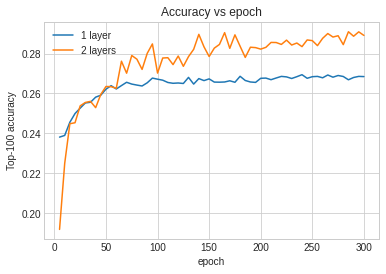

In [82]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [83]:
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.27.


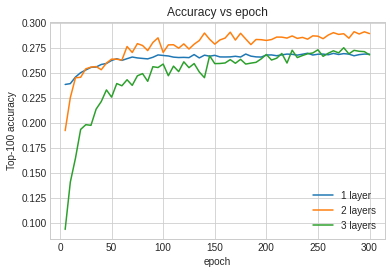

In [84]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

# Multi Task Recommenders

In [85]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-movies/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-movies/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-movies/0.1.0


In [86]:

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## A multi-task model
There are two critical parts to multi-task recommenders:

1. They optimize for two or more objectives, and so have two or more losses.
2. They share variables between the tasks, allowing for transfer learning.

In [87]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

## Rating Specialized Model

In [88]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [89]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [90]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 13s 979ms/step - root_mean_squared_error: 2.0903 - factorized_top_k/top_1_categorical_accuracy: 2.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0294 - factorized_top_k/top_100_categorical_accuracy: 0.0589 - loss: 4.0315 - regularization_loss: 0.0000e+00 - total_loss: 4.0315
Epoch 2/3
10/10 [==============================] - 10s 986ms/step - root_mean_squared_error: 1.1531 - factorized_top_k/top_1_categorical_accuracy: 1.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0297 - factorized_top_k/top_100_categorical_accuracy: 0.0591 - loss: 1.3189 - regularization_loss: 0.0000e+00 - total_loss: 1.3189
Epoch 3/3
5/5 [==============================] - 5s 543ms/step - root_mean_squared_error: 1.1130 - facto

## Retrieval Specialized Model

In [91]:
model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [92]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 10s 944ms/step - root_mean_squared_error: 3.7238 - factorized_top_k/top_1_categorical_accuracy: 7.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0041 - factorized_top_k/top_50_categorical_accuracy: 0.0473 - factorized_top_k/top_100_categorical_accuracy: 0.1135 - loss: 69818.0291 - regularization_loss: 0.0000e+00 - total_loss: 69818.0291
Epoch 2/3
10/10 [==============================] - 10s 949ms/step - root_mean_squared_error: 3.7495 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0116 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.1425 - factorized_top_k/top_100_categorical_accuracy: 0.2658 - loss: 67473.2891 - regularization_loss: 0.0000e+00 - total_loss: 67473.2891
Epoch 3/3
5/5 [==============================] - 3s 530ms/step - root_mean_squared_error: 3.

## Joint Model

In [93]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [94]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 10s 952ms/step - root_mean_squared_error: 2.5007 - factorized_top_k/top_1_categorical_accuracy: 3.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0043 - factorized_top_k/top_50_categorical_accuracy: 0.0450 - factorized_top_k/top_100_categorical_accuracy: 0.1102 - loss: 69811.8274 - regularization_loss: 0.0000e+00 - total_loss: 69811.8274
Epoch 2/3
10/10 [==============================] - 10s 950ms/step - root_mean_squared_error: 1.2097 - factorized_top_k/top_1_categorical_accuracy: 9.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0110 - factorized_top_k/top_10_categorical_accuracy: 0.0255 - factorized_top_k/top_50_categorical_accuracy: 0.1385 - factorized_top_k/top_100_categorical_accuracy: 0.2605 - loss: 67481.2720 - regularization_loss: 0.0000e+00 - total_loss: 67481.2720
Epoch 3/3
5/5 [==============================] - 3s 524ms/step - root_mean_squared_error

## Making Prediction

In [95]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(["42"]),
      "movie_title": np.array(["Dances with Wolves (1990)"])
  })
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[3.402295]], shape=(1, 1), dtype=float32)


# Deep & Cross Network (DCN)

In [96]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

In [97]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

## Model construction

We're going to try out both cross network and deep network to illustrate the advantage a cross network can bring to recommenders. As the data we just created only contains 2nd-order feature interactions, it would be sufficient to illustrate with a single-layered cross network. If we wanted to model higher-order feature interactions, we could stack multiple cross layers and use a multi-layered cross network. The two models we will be building are:

1. Cross Network with only one cross layer;
2. Deep Network with wider and deeper ReLU layers.
We first build a unified model class whose loss is the mean squared error.

In [98]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    x = self._model(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

In [99]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

## Model Training

In [100]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

In [101]:
epochs = 100
learning_rate = 0.4

In [102]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [103]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

## Model Evaluation

In [104]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0007 using 16 parameters.
DeepNet(large) RMSE is 0.0582 using 166401 parameters.


## Model Understanding

<Figure size 648x648 with 0 Axes>

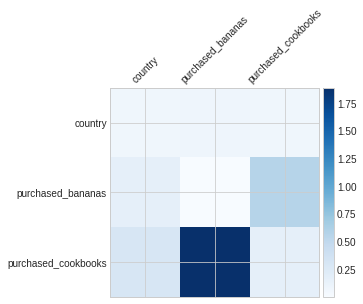

In [106]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

In [107]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: movie_lens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /tmp/tmpvnsfu0x0tfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset movie_lens (/root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Skipping download of http://files.grouplens.org/datasets/movielens/ml-100k.zip: File cached in /root/tensorflow_datasets/downloads/files.grouple.org_dataset_moviele_ml-100kUNKpgsZphpN765_7Oqdu_pVb89XGt2H046fNcXxqMik.zip
INFO:absl:Reusing extraction of /root/tensorflow_datasets/downloads/files.grouple.org_dataset_moviele_ml-100kUNKpgsZphpN765_7Oqdu_pVb89XGt2H046fNcXxqMik.zip at /root/tensorflow_datasets/downloads/extracted/ZIP.files.grouple.org_dataset_moviele_ml-100kUNKpgsZphpN765_7Oqdu_pVb89XGt2H046fNcXxqMik.zip.


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0.incompleteILOF4G/movie_lens-train.tfrecord*.…

INFO:absl:Done writing /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0.incompleteILOF4G/movie_lens-train.tfrecord*. Number of examples: 100000 (shards: [100000])
INFO:absl:Constructing tf.data.Dataset movie_lens for split train, from /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0


Dataset movie_lens downloaded and prepared to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [108]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [109]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

## Model Construction

In [110]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

## Model Training

In [111]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [112]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [113]:
epochs = 8
learning_rate = 0.01

In [114]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 5ms/step - RMSE: 0.9339 - loss: 0.8729 - regularization_loss: 0.0000e+00 - total_loss: 0.8729


In [115]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 5ms/step - RMSE: 0.9300 - loss: 0.8657 - regularization_loss: 0.0000e+00 - total_loss: 0.8657


In [116]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 5ms/step - RMSE: 0.9377 - loss: 0.8798 - regularization_loss: 0.0000e+00 - total_loss: 0.8798


In [117]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9332, stdv: 0.0015
DCN (low-rank) RMSE mean: 0.9312, stdv: 0.0013
DNN            RMSE mean: 0.9388, stdv: 0.0037


## Model Understanding

The weight matrix  in DCN reveals what feature crosses the model has learned to be important. Recall that in the previous toy example, the importance of interactions between the -th and -th features is captured by the ()-th element of .

What's a bit different here is that the feature embeddings are of size 32 instead of size 1. Hence, the importance will be characterized by the -th block  which is of dimension 32 by 32. In the following, we visualize the Frobenius norm
 of each block, and a larger norm would suggest higher importance (assuming the features' embeddings are of similar scales).

Besides block norm, we could also visualize the entire matrix, or the mean/median/max value of each block.

<Figure size 648x648 with 0 Axes>

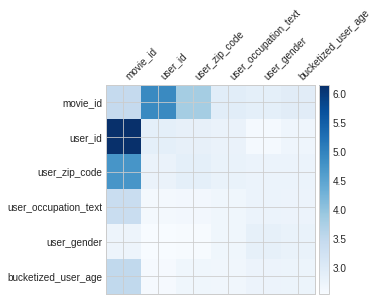

In [118]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

# Efficient Serving

In [119]:
# Load the MovieLens 100K data.
ratings = tfds.load(
    "movielens/100k-ratings",
    split="train"
)

# Get the ratings data.
ratings = (ratings
           # Retain only the fields we need.
           .map(lambda x: {"user_id": x["user_id"], "movie_title": x["movie_title"]})
           # Cache for efficiency.
           .cache(tempfile.NamedTemporaryFile().name)
)

# Get the movies data.
movies = tfds.load("movielens/100k-movies", split="train")
movies = (movies
          # Retain only the fields we need.
          .map(lambda x: x["movie_title"])
          # Cache for efficiency.
          .cache(tempfile.NamedTemporaryFile().name))

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-movies/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-movies/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-movies/0.1.0


In [120]:
user_ids = ratings.map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(user_ids.batch(1000))))

In [121]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

## Model Definition

In [122]:
class MovielensModel(tfrs.Model):

  def __init__(self):
    super().__init__()

    embedding_dimension = 32

    # Set up a model for representing movies.
    self.movie_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      # We add an additional embedding to account for unknown tokens.
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Set up a model for representing users.
    self.user_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Set up a task to optimize the model and compute metrics.
    self.task = tfrs.tasks.Retrieval(
      metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).cache().map(self.movie_model)
      )
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.

    return self.task(user_embeddings, positive_movie_embeddings, compute_metrics=not training)

## Fitting and Evaluation

In [123]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [124]:
model.fit(train.batch(8192), epochs=3)

Epoch 1/3
10/10 [==============================] - 1s 47ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69808.9680 - regularization_loss: 0.0000e+00 - total_loss: 69808.9680
Epoch 2/3
10/10 [==============================] - 1s 43ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 67485.8828 - regularization_loss: 0.0000e+00 - total_loss: 67485.8828
Epoch 3/3
10/10 [==============================] - 1s 47ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - fact

In [125]:
model.evaluate(test.batch(8192), return_dict=True)

3/3 [==============================] - 3s 743ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0092 - factorized_top_k/top_10_categorical_accuracy: 0.0226 - factorized_top_k/top_50_categorical_accuracy: 0.1263 - factorized_top_k/top_100_categorical_accuracy: 0.2360 - loss: 49466.8740 - regularization_loss: 0.0000e+00 - total_loss: 49466.8740


{'factorized_top_k/top_1_categorical_accuracy': 0.0012499999720603228,
 'factorized_top_k/top_5_categorical_accuracy': 0.009150000289082527,
 'factorized_top_k/top_10_categorical_accuracy': 0.022600000724196434,
 'factorized_top_k/top_50_categorical_accuracy': 0.12630000710487366,
 'factorized_top_k/top_100_categorical_accuracy': 0.23604999482631683,
 'loss': 28242.830078125,
 'regularization_loss': 0,
 'total_loss': 28242.830078125}

## Approximate Prediction

In [126]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
brute_force.index_from_dataset(
    movies.batch(128).map(lambda title: (title, model.movie_model(title)))
)

In [127]:
# Get predictions for user 42.
_, titles = brute_force(np.array(["42"]), k=3)

print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


In [128]:
%timeit _, titles = brute_force(np.array(["42"]), k=3)

1.51 ms ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [129]:
# Construct a dataset of movies that's 1,000 times larger. We 
# do this by adding several million dummy movie titles to the dataset.
lots_of_movies = tf.data.Dataset.concatenate(
    movies.batch(4096),
    movies.batch(4096).repeat(1_000).map(lambda x: tf.zeros_like(x))
)

# We also add lots of dummy embeddings by randomly perturbing
# the estimated embeddings for real movies.
lots_of_movies_embeddings = tf.data.Dataset.concatenate(
    movies.batch(4096).map(model.movie_model),
    movies.batch(4096).repeat(1_000)
      .map(lambda x: model.movie_model(x))
      .map(lambda x: x * tf.random.uniform(tf.shape(x)))
)

In [130]:
brute_force_lots = tfrs.layers.factorized_top_k.BruteForce()
brute_force_lots.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

In [131]:
_, titles = brute_force_lots(model.user_model(np.array(["42"])), k=3)

print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


In [132]:
%timeit _, titles = brute_force_lots(model.user_model(np.array(["42"])), k=3)

3.14 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## ScaNN

In [133]:
scann = tfrs.layers.factorized_top_k.ScaNN(num_reordering_candidates=100)
scann.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

In [134]:
_, titles = scann(model.user_model(np.array(["42"])), k=3)

print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


In [135]:
%timeit _, titles = scann(model.user_model(np.array(["42"])), k=3)

22.7 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Evaluating the Approximation

When using approximate top K retrieval mechanisms (such as ScaNN), speed of retrieval often comes at the expense of accuracy. To understand this trade-off, it's important to measure the model's evaluation metrics when using ScaNN, and to compare them with the baseline.

Fortunately, TFRS makes this easy. We simply override the metrics on the retrieval task with metrics using ScaNN, re-compile the model, and run evaluation.

To make the comparison, let's first run baseline results. We still need to override our metrics to make sure they are using the enlarged candidate set rather than the original set of movies:


In [136]:
# Override the existing streaming candidate source.
model.task.factorized_metrics = tfrs.metrics.FactorizedTopK(
    candidates=lots_of_movies_embeddings
)
# Need to recompile the model for the changes to take effect.
model.compile()

%time baseline_result = model.evaluate(test.batch(8192), return_dict=True, verbose=False)

CPU times: user 16min 32s, sys: 6.87 s, total: 16min 39s
Wall time: 8min 49s


### ScaNN based evaluation is much, much quicker: 

In [137]:
model.task.factorized_metrics = tfrs.metrics.FactorizedTopK(
    candidates=scann
)
model.compile()

# We can use a much bigger batch size here because ScaNN evaluation
# is more memory efficient.
%time scann_result = model.evaluate(test.batch(8192), return_dict=True, verbose=False)

CPU times: user 5.38 s, sys: 301 ms, total: 5.68 s
Wall time: 3.31 s


In [138]:
print(f"Brute force top-100 accuracy: {baseline_result['factorized_top_k/top_100_categorical_accuracy']:.2f}")
print(f"ScaNN top-100 accuracy:       {scann_result['factorized_top_k/top_100_categorical_accuracy']:.2f}")

Brute force top-100 accuracy: 0.15
ScaNN top-100 accuracy:       0.27


## Deploying the approximate model

In [139]:
lots_of_movies_embeddings

<ConcatenateDataset element_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)>

In [140]:
# We re-index the ScaNN layer to include the user embeddings in the same model.
# This way we can give the saved model raw features and get valid predictions
# back.
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model, num_reordering_candidates=1000)
scann.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

# Need to call it to set the shapes.
_ = scann(np.array(["42"]))

with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")
  tf.saved_model.save(
      scann,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  loaded = tf.saved_model.load(path)

INFO:tensorflow:Assets written to: /tmp/tmphopah__n/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphopah__n/model/assets


In [141]:
_, titles = loaded(tf.constant(["42"]))

print(f"Top recommendations: {titles[0][:3]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


## Tuning ScaNN

In [142]:
titles_ground_truth = tf.concat([
  brute_force_lots(queries, k=10)[1] for queries in
  test.batch(1000).map(lambda x: model.user_model(x["user_id"]))
], axis=0)

In [143]:
# Get all user_id's as a 1d tensor of strings
test_flat = np.concatenate(list(test.map(lambda x: x["user_id"]).batch(1000).as_numpy_iterator()), axis=0)

# ScaNN is much more memory efficient and has no problem processing the whole
# batch of 20000 queries at once.
_, titles = scann(test_flat, k=10)

In [144]:
def compute_recall(ground_truth, approx_results):
  return np.mean([
      len(np.intersect1d(truth, approx)) / len(truth)
      for truth, approx in zip(ground_truth, approx_results)
  ])

In [145]:
print(f"Recall: {compute_recall(titles_ground_truth, titles):.3f}")

Recall: 0.931


In [146]:
%timeit -n 1000 scann(np.array(["42"]), k=10)

21.9 ms ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [147]:
scann2 = tfrs.layers.factorized_top_k.ScaNN(
    model.user_model, 
    num_leaves=1000,
    num_leaves_to_search=100,
    num_reordering_candidates=1000)
scann2.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

_, titles2 = scann2(test_flat, k=10)

print(f"Recall: {compute_recall(titles_ground_truth, titles2):.3f}")

Recall: 0.966


In [148]:
%timeit -n 1000 scann2(np.array(["42"]), k=10)

21.9 ms ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [149]:
scann3 = tfrs.layers.factorized_top_k.ScaNN(
    model.user_model,
    num_leaves=1000,
    num_leaves_to_search=70,
    num_reordering_candidates=400)
scann3.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

_, titles3 = scann3(test_flat, k=10)
print(f"Recall: {compute_recall(titles_ground_truth, titles3):.3f}")

Recall: 0.958


In [150]:
%timeit -n 1000 scann3(np.array(["42"]), k=10)

21.8 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Listwise Ranking

In [151]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-ratings/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-ratings/0.1.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/movielens/100k-movies/0.1.0
INFO:absl:Reusing dataset movielens (/root/tensorflow_datasets/movielens/100k-movies/0.1.0)
INFO:absl:Constructing tf.data.Dataset movielens for split train, from /root/tensorflow_datasets/movielens/100k-movies/0.1.0


In [152]:
tf.random.set_seed(42)

# Split between train and tests sets, as before.
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# We sample 50 lists for each user for the training data. For each list we
# sample 5 movies from the movies the user rated.
train = tfrs.examples.movielens.sample_listwise(
    train,
    num_list_per_user=50,
    num_examples_per_list=5,
    seed=42
)
test = tfrs.examples.movielens.sample_listwise(
    test,
    num_list_per_user=1,
    num_examples_per_list=5,
    seed=42
)

## Model Definition
We will train the same model with three different losses:

1. mean squared error,
2. pairwise hinge loss, and
3. a listwise ListMLE loss.

In [153]:
class RankingModel(tfrs.Model):

  def __init__(self, loss):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids),
      tf.keras.layers.Embedding(len(unique_user_ids) + 2, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 2, embedding_dimension)
    ])

    # Compute predictions.
    self.score_model = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

    self.task = tfrs.tasks.Ranking(
      loss=loss,
      metrics=[
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
        tf.keras.metrics.RootMeanSquaredError()
      ]
    )

  def call(self, features):
    # We first convert the id features into embeddings.
    # User embeddings are a [batch_size, embedding_dim] tensor.
    user_embeddings = self.user_embeddings(features["user_id"])

    # Movie embeddings are a [batch_size, num_movies_in_list, embedding_dim]
    # tensor.
    movie_embeddings = self.movie_embeddings(features["movie_title"])

    # We want to concatenate user embeddings with movie emebeddings to pass
    # them into the ranking model. To do so, we need to reshape the user
    # embeddings to match the shape of movie embeddings.
    list_length = features["movie_title"].shape[1]
    user_embedding_repeated = tf.repeat(
        tf.expand_dims(user_embeddings, 1), [list_length], axis=1)

    # Once reshaped, we concatenate and pass into the dense layers to generate
    # predictions.
    concatenated_embeddings = tf.concat(
        [user_embedding_repeated, movie_embeddings], 2)

    return self.score_model(concatenated_embeddings)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")

    scores = self(features)

    return self.task(
        labels=labels,
        predictions=tf.squeeze(scores, axis=-1),
    )

## Training the Models

In [154]:
epochs = 30

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## Mean squared error model

In [158]:
! pip install -q tensorflow-ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 5.2 MB/s eta 0:00:00


In [159]:
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

mse_model = RankingModel(tf.keras.losses.MeanSquaredError())
mse_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [160]:
mse_model.fit(cached_train, epochs=epochs, verbose=False)

## Pairwise hinge loss model

In [161]:
hinge_model = RankingModel(tfr.keras.losses.PairwiseHingeLoss())
hinge_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [162]:
hinge_model.fit(cached_train, epochs=epochs, verbose=False)

## Listwise Model

In [163]:
listwise_model = RankingModel(tfr.keras.losses.ListMLELoss())
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [164]:
listwise_model.fit(cached_train, epochs=epochs, verbose=False)

## Comparing the Models

In [165]:
mse_model_result = mse_model.evaluate(cached_test, return_dict=True)
print("NDCG of the MSE Model: {:.4f}".format(mse_model_result["ndcg_metric"]))

1/1 [==============================] - 0s 415ms/step - ndcg_metric: 0.9053 - root_mean_squared_error: 0.9671 - loss: 0.9354 - regularization_loss: 0.0000e+00 - total_loss: 0.9354
NDCG of the MSE Model: 0.9053


In [166]:
hinge_model_result = hinge_model.evaluate(cached_test, return_dict=True)
print("NDCG of the pairwise hinge loss model: {:.4f}".format(hinge_model_result["ndcg_metric"]))

1/1 [==============================] - 0s 475ms/step - ndcg_metric: 0.9058 - root_mean_squared_error: 3.8329 - loss: 1.0180 - regularization_loss: 0.0000e+00 - total_loss: 1.0180
NDCG of the pairwise hinge loss model: 0.9058


In [167]:
listwise_model_result = listwise_model.evaluate(cached_test, return_dict=True)
print("NDCG of the ListMLE model: {:.4f}".format(listwise_model_result["ndcg_metric"]))

1/1 [==============================] - 0s 464ms/step - ndcg_metric: 0.9070 - root_mean_squared_error: 2.7222 - loss: 4.5401 - regularization_loss: 0.0000e+00 - total_loss: 4.5401
NDCG of the ListMLE model: 0.9070


## Conclusion 

Of the three models, the model trained using ListMLE has the highest NDCG metric. This result shows how listwise optimization can be used to train ranking models and can potentially produce models that perform better than models optimized in a pointwise or pairwise fashion.